#CMPE 258 HW3 - Part B2
Pytorch to build neural network of 3d input, 2d output with auto differentiation

Abhishek Bais

In [1]:
# Import packages
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

# Generate 3d input, 2d output

In [2]:
# Generate 3-d input, 2d output
n = 100
d = 3
r1 = -1
r2 = 1
x = (r1 - r2) * torch.rand((n, d)) + r2

# y = 5x^2 + wx + b
weights_true = torch.tensor([[3., 2., -1.], [2., 3., 1.]]).T
bias_true = torch.tensor([[0.5], [0.5]]).T
print(x.shape, weights_true.shape, bias_true.shape)

y_true = torch.mm(5 * x ** 2, weights_true) + torch.mm(x, weights_true) + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

print('x is: ' + str(x[:2]))
print('y is: ' + str(y_true[:2]))

torch.Size([100, 3]) torch.Size([3, 2]) torch.Size([1, 2])
x: torch.Size([100, 3]), weights: torch.Size([3, 2]), bias: torch.Size([1, 2]), y: torch.Size([100, 2])
x is: tensor([[ 0.9184,  0.9906,  0.3372],
        [ 0.0523, -0.3459, -0.7017]])
y is: tensor([[26.7942, 29.3669],
        [-0.5573,  3.1490]])


# Generate a 3d TSNE plot of the data

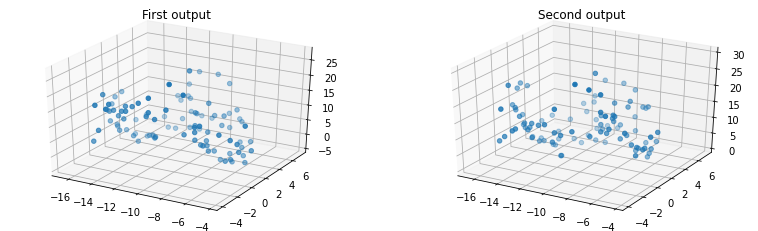

In [3]:
# Generate 3D TSNE plots for both outputs
def plot_3d(X, y, y_pred=None):
  X_tnse = TSNE(n_components=2, random_state=123).fit_transform(X)
  fig = plt.figure(figsize=plt.figaspect(0.3))
  
  # plot the first output y[:,0]
  ax = fig.add_subplot(1, 2, 1, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y[:,0], label='y_true')
  ax.set_title("First output")
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred[:,0], label='y_pred', marker='v')
  
  # plot the second output y[:,1]
  ax = fig.add_subplot(1, 2, 2, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y[:,1], label='y_true')
  ax.set_title("Second output")
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred[:,1], label='y_pred', marker='v')
  
plot_3d(x, y_true)

# Define a loss function
MSE

In [4]:
# Loss Function with gradient descent
class MSE:
  def __init__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true

  def loss(self):
    n = self.y_true.shape[0]
    return ((self.y_pred - self.y_true) ** 2) / n
        
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2 * (self.y_pred - self.y_true) / n
    return self.gradient

# Define activation functions
Relu for auto differentiation

In [5]:
# RELU non-linear layer class
class Relu:
  def __init__(self):
    self.input_ = torch.tensor([])

  def forward(self, input_):
    self.input_  = input_
    self.output = torch.clamp(self.input_, min=0)
    return self.output
  
  # gradient computation no longer needed
  def backward(self):
    return
  
  def update(self, lr):
    return

# Define backpropagation with autograd for Linear, Relu layers

In [6]:
# Layer class with backpropagation 
# Default activation is linear, pass in activation='relu' for non-linear
class Layer:
  # Init
  def __init__(self, ni=1, no=1, activation='Linear'):
    self.ni = ni
    self.no = no
    self.activation = 'Linear'

    # Init
    r1 = -1
    r2 = 1
    self.weights = (r1 - r2) * torch.rand((ni, no), requires_grad=True) + r2
    self.bias = torch.rand((1), requires_grad=True)
    self.x = torch.zeros((ni))
  
    # activation
    if activation == 'Relu':
      self.activation = Relu()
  
  # Forward propagate input, output, weights, bias gradient
  def forward(self, x):
    self.x = x
    self.output = torch.mm(x, self.weights) + self.bias
    self.weights.retain_grad()
    self.bias.retain_grad()

   # Pass output to activation function
    if self.activation != 'Linear':
      return self.activation.forward(self.output)
    else:
      return self.output 

  # Backpropagate gradients, upstream gradient not required
  def backward(self):
    if self.activation != 'Linear':
      self.activation.backward()   
    self.weights_gradient = self.weights.grad
    self.bias_gradient = self.bias.grad

  # Update weights, bias
  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient
    
  # Print the layer params
  def dump(self):
    print('Layer has ni', self.ni)
    print('Layer has no', self.no)
    print('Layer has activation function', self.activation)
    print('Layer has weights', self.weights)
    print('Layer has bias', self.bias)

# Build the nueral net

In [7]:
# Custom Model using nn.Linear modules
class Model:
  # Dump NN
  def dump(self):
    print('Builiding NN:')
    for j, layer in enumerate(self.layers):
      print('---- Layer {} ----'.format(j))
      layer.dump()

  # Init
  def __init__(self, ni=3, nh=[2], no=2, activation='Linear'):
    self.ni = ni
    self.nh = nh
    self.no = no

    # Build a chain of layers to form the NN
    self.layers = []
    self.layers.append(Layer(ni, no, activation='Linear'))
    self.layers.append(Layer(no, 5, activation))
    self.layers.append(Layer(5, 2, activation))
        
  # Dump the model created
    self.dump()
    
  # Forward propagate
  def forward(self, inputs):
    o = inputs
    for l in self.layers:
      o = l.forward(o)
    return o
  
  # Back propagate loss, gradients
  def backward(self, y_pred, y_true):
    outer_gradient = torch.ones(y_true.shape)
    mse = MSE(y_pred, y_true)
    loss = mse.loss()
    loss.backward(gradient=outer_gradient, retain_graph=True)
    for layer in reversed(self.layers):
      layer.backward()

  # Forward propagate  
  def update(self, lr):
    for layer in self.layers:
      layer.update(lr)
  
  # Train model
  def fit(self, x, y_true, lr, num_epochs):
    print('Propagating input: ' + str(x[:2]))
    for epoch in range(num_epochs):
      y_pred = self.forward(x)
      self.backward(y_pred, y_true)
      self.update(lr)

# Train neural net with non-linear relu layer

In [8]:
# Configure hyperparams of model
num_epochs = 40
lr = 0.01
ni = x.shape[1]
no = y_true.shape[1]
nh = [5,3]

In [9]:
nn = Model(ni, nh, no=no, activation='Relu')
nn.fit(x, y_true, lr, num_epochs)
y_pred = nn.forward(x).detach().numpy()

loss = mean_squared_error(y_true, y_pred)
print('Final Loss is ', loss)

Builiding NN:
---- Layer 0 ----
Layer has ni 3
Layer has no 2
Layer has activation function Linear
Layer has weights tensor([[ 0.8414,  0.9081],
        [ 0.7459,  0.8449],
        [-0.3129,  0.8057]], grad_fn=<AddBackward0>)
Layer has bias tensor([0.8653], requires_grad=True)
---- Layer 1 ----
Layer has ni 2
Layer has no 5
Layer has activation function <__main__.Relu object at 0x7f1f5eb410d0>
Layer has weights tensor([[ 0.2994, -0.5178,  0.9628,  0.2104,  0.8814],
        [ 0.0226, -0.9160, -0.2832,  0.7462, -0.0893]], grad_fn=<AddBackward0>)
Layer has bias tensor([0.0853], requires_grad=True)
---- Layer 2 ----
Layer has ni 5
Layer has no 2
Layer has activation function <__main__.Relu object at 0x7f1f5eb41190>
Layer has weights tensor([[ 0.6944, -0.1600],
        [-0.7125,  0.8892],
        [ 0.6803,  0.7349],
        [-0.1261,  0.0392],
        [-0.1125,  0.2520]], grad_fn=<AddBackward0>)
Layer has bias tensor([0.7306], requires_grad=True)
Propagating input: tensor([[ 0.9184,  0.9906

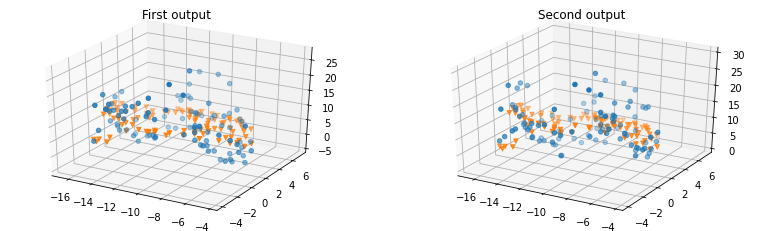

In [10]:
plot_3d(x, y_true, y_pred)

# Train neural net with only linear layers

In [11]:
nn = Model(ni, nh, no, activation='Linear')
nn.fit(x, y_true, lr, num_epochs)
y_pred = nn.forward(x).detach().numpy()

loss = mean_squared_error(y_true, y_pred)
print('Final Loss is ', loss)

Builiding NN:
---- Layer 0 ----
Layer has ni 3
Layer has no 2
Layer has activation function Linear
Layer has weights tensor([[ 0.3633,  0.9872],
        [-0.5308, -0.3222],
        [-0.1262,  0.7732]], grad_fn=<AddBackward0>)
Layer has bias tensor([0.0292], requires_grad=True)
---- Layer 1 ----
Layer has ni 2
Layer has no 5
Layer has activation function Linear
Layer has weights tensor([[ 0.1644, -0.7653,  0.8028, -0.8891,  0.4560],
        [-0.4448, -0.3656, -0.1414,  0.3926, -0.3376]], grad_fn=<AddBackward0>)
Layer has bias tensor([0.1632], requires_grad=True)
---- Layer 2 ----
Layer has ni 5
Layer has no 2
Layer has activation function Linear
Layer has weights tensor([[-0.3744, -0.5057],
        [-0.3314,  0.6592],
        [ 0.5913,  0.5747],
        [-0.1694, -0.7819],
        [ 0.8183, -0.1089]], grad_fn=<AddBackward0>)
Layer has bias tensor([0.9570], requires_grad=True)
Propagating input: tensor([[ 0.9184,  0.9906,  0.3372],
        [ 0.0523, -0.3459, -0.7017]])
Final Loss is  35.

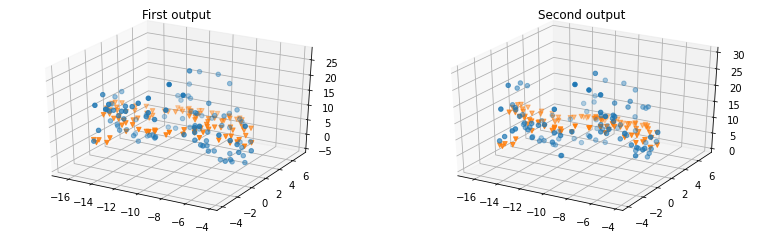

In [12]:
plot_3d(x, y_true, y_pred)